$\newcommand{\v}[1]{\mathbf{#1}}$


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import multinomial
from scipy.stats import multivariate_normal
import seaborn as sns
plt.rcParams['figure.figsize'] = (12,6)

# 1. Introduction
In a lot of situation, we do not have observation of all variables. A canonical example is missing data. Expectation maximization (EM) is a very nice algorithm to cope with this situation. Intuitively, it initializes the parameters of model with some intial values. And then the missing data are estimated by their expectation. Now we have observations on all variables, it is easy to maximize the likelihood function with respect to the parameters. Using the newly estimated parameters, it again estimated the missing data and compute new values for parameters. This process is repeated until convergece of the likelihood function or the estimated values of missing data. 

The terminology for variables that we do not have data about them is **hidden variables**. And the variables that we have data about them is **observed variables**. Concretely, given a probablistic model, $p(X,Z\mid \theta)$, where $X$ are observed variables and $Z$ are hidden variables, our job is to maximize the likehood function $p(X \mid \theta)$ with respect to $\theta$. $\theta$ represents all the parameters of the probablistic model $p(X,Z|\theta)$. This is difficult since the values of $Z$ are hidden. If we know the values of $Z$ then  it is often easy to optimize the likehood function by just deriving its functional form and apply any opitimization technique such as gradient ascent.

The general steps of EM is as follows.

1. $\theta^{old} = \theta^{initial}$
2. **E-step:** Evaluate $p(Z \mid X, \theta^{old})$
3. **M-step:** Evaluate $\theta^{new}$ given by $\theta^{new} = argmax_{\theta} Q(\theta, \theta^{old}),$ where $Q(\theta, \theta^{old})$ are the expectation of complete log likelihood wrt the posterior condiational distribution of hidden variables $Z$: $Q(\theta, \theta^{old}) = \sum_{Z}p(Z \mid X, \theta^{old})\ln p(X, Z \mid \theta)$
4. Check the convergence of either log likelihood or parameter values. If the convergence criterio is not satisfied then let $\theta^{old} = \theta^{new}$, repeat step 2.

# 2. K-means Clustering

The k-means clustering is a simple clustering algorithm and it will help us illustrating the concept of EM.

Given a data set $\{\v{x}_1, \dots, \v{x}_N\}$, and the number of cluster $K$, we want to label each data points with a cluster label from 1 to K. 

We introduce an indicator variable $r_{nk}$ which is 1 if $\v{x}_1$ is assigned to cluster k, and 0 otherwise. 

Intuitively, we want to label data points so that the distances among points in the same cluster is small relatively to points that are outside the cluster. To formalize this intuition, we  introduce K prototype vectors $\mu_k$, which can be thought of as a representative for each cluster. 

Hence to discover clusters of data points, we need to minize the following quantity: $$J = \sum_{n=1}^{N}\sum_{k=1}^{K}r_{nk}|x_n - \mu_k|^2$$.

Note that we use two single vertical bars to denote the norm-2 of a vector, i.e., its length.

Our goal is to find $\{r_{nk}\}$ and $\{\mu_k\}$ to minize J. We can use EM to solve this problem:

1. **E-step**: Updating $\{r_{nk}\}$ (hidden variable) $r_{nk} = 1$ if $k = argmin_j |x_n - \mu_j|^2$, 0 otherwise.
2. **M-step**: Updating $\{\mu_k\}$ (reestimate model parameters) 
    - $$\mu_k = \frac{\sum_n r_{nk}x_n}{\sum_n r_{nk}}$$
3. Repeat until convergence or max iteration is reached

In [10]:
from scipy.spatial.distance import cdist

class KMeans(object):

    def __init__(self, n_clusters):
        self.n_clusters = n_clusters

    def fit(self, X, iter_max=100):
        """
        perform k-means algorithm

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input data
        iter_max : int
            maximum number of iterations

        Returns
        -------
        centers : (n_clusters, n_features) ndarray
            center of each cluster
        """
        I = np.eye(self.n_clusters)
        centers = X[np.random.choice(len(X), self.n_clusters, replace=False)]
        for _ in range(iter_max):
            prev_centers = np.copy(centers)
            
            # E-step recompute cluster assignment
            D = cdist(X, centers)
            cluster_index = np.argmin(D, axis=1)
            cluster_index = I[cluster_index]
            # M-step recompute cluster
            # http://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc
            centers = np.sum(X[:, np.newaxis, :] * cluster_index[:, :, np.newaxis], axis=0) / np.sum(cluster_index, axis=0)[:, np.newaxis]
            
            # check for convergence of cluster
            if np.allclose(prev_centers, centers):
                break
        self.centers = centers

    def predict(self, X):
        """
        calculate closest cluster center index

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input data

        Returns
        -------
        index : (sample_size,) ndarray
            indicates which cluster they belong
        """
        D = cdist(X, self.centers)
        return np.argmin(D, axis=1)

In [11]:
np.random.seed(2018)

In [12]:
# training data
x1 = np.random.normal(size=(100, 2))
x1 += np.array([-5, -5])
x2 = np.random.normal(size=(100, 2))
x2 += np.array([5, -5])
x3 = np.random.normal(size=(100, 2))
x3 += np.array([0, 5])
x_train = np.vstack((x1, x2, x3))

x0, x1 = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
x = np.array([x0, x1]).reshape(2, -1).T

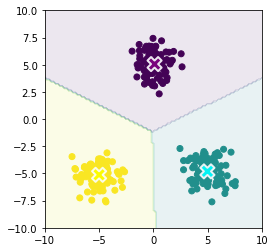

In [13]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(x_train)
cluster = kmeans.predict(x_train)
plt.scatter(x_train[:, 0], x_train[:, 1], c=cluster)
plt.scatter(kmeans.centers[:, 0], kmeans.centers[:, 1], s=200, marker='X', lw=2, c=['purple', 'cyan', 'yellow'], edgecolor="white")
plt.contourf(x0, x1, kmeans.predict(x).reshape(100, 100), alpha=0.1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# 3. Gaussian Mixture Model (GMM)



$$p(x \mid \{\theta_k\}) = \sum_k \pi_k N(x \mid \mu_k, \Sigma_k)$$

,where $\pi_k$ are mixing coefficients and $\sum_k \pi_k = 1$.

We can view the above formula from the latent variable point of view by introducing a latent variable $z$ having K possible states and encode $z$ using 1-of-K representation in which a particular element $z_k$ is equal to 1 and all other elements are equal to 0. The values of $z_k$ therefore satisify $z_k \in {0,1}$ and $\sum_k z_k = 1$. We define the joint distribution $p(\v{x}, \v{z})$ in terms of $p(\v{z})$ and $p(\v{x} \mid \v{z})$

We have $$p(\v{z}) = \prod_{k=1}^{K}\pi_k^{z_k}$$

and 

$$p(\v{x} \mid \v{z}) = \prod_{k=1}^{K}\cal{N}(\mu_k, \Sigma_k)^{z_k}$$

Then we have

$$p(\v{x}) = \sum_{\v{z}}p(\v{x} \mid \v{z})p(\v{z}) = \sum_k \pi_k N(\v{x} \mid \mu_k, \Sigma_k)$$

### Ancestral Sampling for GMM


In [14]:
# True parameter values
mu_true = np.array([2, 5, 10])
sigma_true = np.array([0.6, 0.8, 0.5])
lambda_true = np.array([.4, .2, .4])
n = 10000
# Simulate from each distribution according to mixing proportion lambda
z = multinomial.rvs(1, lambda_true, size=n)

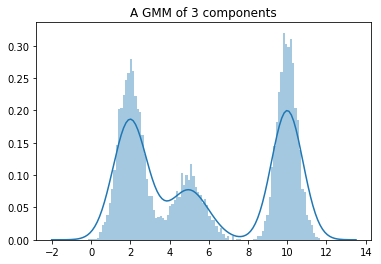

In [15]:
x=np.array([np.random.normal(mu_true[i.astype('bool')][0],
                             sigma_true[i.astype('bool')][0]) for i in z])
sns.distplot(x, bins=100);
plt.gca().set_title('A GMM of 3 components');

### MLE for GMM

We have $$\ln p(\v{X} \mid \v{\pi}, \v{\mu}, \v{\Sigma}) = \sum_{n=1}^{N}\ln (\sum_{k=1}^{K} \pi_k)\cal{N}(\v{x} \mid \v{\mu}_k, \v{\Sigma}_k)$$

There are three sets of parameters $\mu_k, \Sigma_k, \pi_k$, because of the sum inside the logarithm, we will not find a closed form solution when minimizing the log likelihood of a GMM. This is the reason why we use EM to optimize the log likelihood. For derivation of ML formula, please refer to Bishop book.

### EM for GMM
In this section, we will derive the EM algorithm steps for GMM using the guidance of the general algorithm of EM that we discussed at the beginning. But first, let's look at the graphical representation of GMM is as follows: 

![graphical representation of GMM](./gfx/gmm.pdf)

The node $x_n$ is shaded because $x_n$ is an observed variables. The plate repsentation a duplication of variables that are insided it. The index that is at the bottom right corner of the plate indicates how many times the reptition is done. Here we have $N$ data points so the number of reptition will be $N$.

We have the log-likelihood of complete data:
\begin{align}
\ln p(\v{X},\v{Z}) &=  \ln \prod_{n=1}^{N}\prod_{k=1}^{K}\pi_k^{z_{nk}} N(x_n | \mu_k, \Sigma_k)^{z_{nk}}\\
                    &= \sum_{n=1}^{N} \sum_{k=1}^{K} z_{nk}(\ln \pi_k + \ln N(x_n, | \mu_k, \Sigma_k))
\end{align}

The **E-step** is to compute the expectation of log-likelihood of complete data with respect to the posterior distribution of hidden variables. In GMM, this means computing $$E_{Z}[\ln p(\v{X},\v{Z}|\pi, \mu, \Sigma])$$ with respect to $p(\v{Z}|\v{X}) = \prod_{n=1}^{N}p(z_n|x_n)$, according to the graphical model. The fact that posterior distribution of $\v{Z}$ is factorized over data points is important since then it is easier to compute the expectation of log-likelihood of complete data. That is:

\begin{align}
E_{Z}[\ln p(\v{X},\v{Z}|\pi, \mu, \Sigma]) &= E_{Z}[\sum_{n=1}^{N} \sum_{k=1}^{K} z_{nk}(\ln \pi_k + \ln N(x_n, | \mu_k, \Sigma_k))]\\
                                            &= \sum_{n=1}^{N} \sum_{k=1}^{K} E_{Z}[z_{nk}](\ln \pi_k + \ln N(x_n, | \mu_k, \Sigma_k))]\\
                                            &= \sum_{n=1}^{N} \sum_{k=1}^{K} E_{z_n}[z_{nk}](\ln \pi_k + \ln N(x_n, | \mu_k, \Sigma_k))]
\end{align}

The last equality is due to the factorization of posterior distribution of hidden variables that we have just mentioned above. Now we just need to compute $E_{z_n}[z_{nk}]$! This is easy, we just need to stick to the definition of expectation:

$\begin{align}
E_{z_n}[z_{nk}] &= \sum_{z_n}z_{nk}p(z_n|x_n)\\
\end{align}$

Recall that $p(z_n | x_n) \propto p(z_n)p(x_n|x_n) = \prod_{k^\prime}^{K}\pi_{k^\prime}^{z_{nk^\prime}}\prod_{k^\prime}^{K}N(x_n|\mu_{k^\prime}, \Sigma_{k^\prime})^{z_{nk^\prime}}$ 

Normalizing over all possible values of $z_{n}$, and plug $p(z_n|x_n)$ back, we have:

$$E_{z_n}[z_{nk}] = \frac{\pi_k N(x_n | \mu_k, \Sigma_k)}{ \sum_{j=1}^{K}\pi_j N(x_n | \mu_j, \Sigma_j)} = \gamma(z_{nk})$$

This ammount is called the *responstibility* of component $k$ in explaning the data point $x_n$

The **M-step** is to maximize the expectation of the log-likeklihood of complete data with respect to model parameters. This give rise to the following update rules:

![M-step](../gfx/m_step.png)

That is, now we can have the EM for GMM as follows.

1. Set the means $\v{\mu}$, variances $\v{\Sigma}$, and mixing components $\v{\pi}$ to some intial values. Then evaluate the initial value of the log likelihood. 
2. E-step: Evaluate the responsibilities using the current parameters: $$\gamma(z_{nk}) = \frac{\pi_k N(\v{x}_n | \v{\mu}_k, \v{\Sigma}_k)}{\sum_{j=1}^{K}\pi_jN(\v{x}_n | \v{\mu}_j, \v{\Sigma}_j)}$$
3. M-step: Re-estimate the parameters using the current responsibilities using the above update rules.
4. Recompute the log-likehood: ![log-likelihood](../gfx/log_likehood.png)

In [16]:
class RandomVariable(object):
    """
    base class for random variables
    """

    def __init__(self):
        self.parameter = {}

    def __repr__(self):
        string = f"{self.__class__.__name__}(\n"
        for key, value in self.parameter.items():
            string += (" " * 4)
            if isinstance(value, RandomVariable):
                string += f"{key}={value:8}"
            else:
                string += f"{key}={value}"
            string += "\n"
        string += ")"
        return string

    def __format__(self, indent="4"):
        indent = int(indent)
        string = f"{self.__class__.__name__}(\n"
        for key, value in self.parameter.items():
            string += (" " * indent)
            if isinstance(value, RandomVariable):
                string += f"{key}=" + value.__format__(str(indent + 4))
            else:
                string += f"{key}={value}"
            string += "\n"
        string += (" " * (indent - 4)) + ")"
        return string

    def fit(self, X, **kwargs):
        """
        estimate parameter(s) of the distribution

        Parameters
        ----------
        X : np.ndarray
            observed data
        """
        self._check_input(X)
        if hasattr(self, "_fit"):
            self._fit(X, **kwargs)
        else:
            raise NotImplementedError

    # def ml(self, X, **kwargs):
    #     """
    #     maximum likelihood estimation of the parameter(s)
    #     of the distribution given data

    #     Parameters
    #     ----------
    #     X : (sample_size, ndim) np.ndarray
    #         observed data
    #     """
    #     self._check_input(X)
    #     if hasattr(self, "_ml"):
    #         self._ml(X, **kwargs)
    #     else:
    #         raise NotImplementedError

    # def map(self, X, **kwargs):
    #     """
    #     maximum a posteriori estimation of the parameter(s)
    #     of the distribution given data

    #     Parameters
    #     ----------
    #     X : (sample_size, ndim) np.ndarray
    #         observed data
    #     """
    #     self._check_input(X)
    #     if hasattr(self, "_map"):
    #         self._map(X, **kwargs)
    #     else:
    #         raise NotImplementedError

    # def bayes(self, X, **kwargs):
    #     """
    #     bayesian estimation of the parameter(s)
    #     of the distribution given data

    #     Parameters
    #     ----------
    #     X : (sample_size, ndim) np.ndarray
    #         observed data
    #     """
    #     self._check_input(X)
    #     if hasattr(self, "_bayes"):
    #         self._bayes(X, **kwargs)
    #     else:
    #         raise NotImplementedError

    def pdf(self, X):
        """
        compute probability density function
        p(X|parameter)

        Parameters
        ----------
        X : (sample_size, ndim) np.ndarray
            input of the function

        Returns
        -------
        p : (sample_size,) np.ndarray
            value of probability density function for each input
        """
        self._check_input(X)
        if hasattr(self, "_pdf"):
            return self._pdf(X)
        else:
            raise NotImplementedError

    def draw(self, sample_size=1):
        """
        draw samples from the distribution

        Parameters
        ----------
        sample_size : int
            sample size

        Returns
        -------
        sample : (sample_size, ndim) np.ndarray
            generated samples from the distribution
        """
        assert isinstance(sample_size, int)
        if hasattr(self, "_draw"):
            return self._draw(sample_size)
        else:
            raise NotImplementedError

    def _check_input(self, X):
        assert isinstance(X, np.ndarray)

class MultivariateGaussianMixture(RandomVariable):
    """
    p(x|mu, L, pi(coef))
    = sum_k pi_k N(x|mu_k, L_k^-1)
    """

    def __init__(self,
                 n_components,
                 mu=None,
                 cov=None,
                 tau=None,
                 coef=None):
        """
        construct mixture of Gaussians

        Parameters
        ----------
        n_components : int
            number of gaussian component
        mu : (n_components, ndim) np.ndarray
            mean parameter of each gaussian component
        cov : (n_components, ndim, ndim) np.ndarray
            variance parameter of each gaussian component
        tau : (n_components, ndim, ndim) np.ndarray
            precision parameter of each gaussian component
        coef : (n_components,) np.ndarray
            mixing coefficients
        """
        super().__init__()
        assert isinstance(n_components, int)
        self.n_components = n_components
        self.mu = mu
        if cov is not None and tau is not None:
            raise ValueError("Cannot assign both cov and tau at a time")
        elif cov is not None:
            self.cov = cov
        elif tau is not None:
            self.tau = tau
        else:
            self.cov = None
            self.tau = None
        self.coef = coef

    @property
    def mu(self):
        return self.parameter["mu"]

    @mu.setter
    def mu(self, mu):
        if isinstance(mu, np.ndarray):
            assert mu.ndim == 2
            assert np.size(mu, 0) == self.n_components
            self.ndim = np.size(mu, 1)
            self.parameter["mu"] = mu
        elif mu is None:
            self.parameter["mu"] = None
        else:
            raise TypeError("mu must be either np.ndarray or None")

    @property
    def cov(self):
        return self.parameter["cov"]

    @cov.setter
    def cov(self, cov):
        if isinstance(cov, np.ndarray):
            assert cov.shape == (self.n_components, self.ndim, self.ndim)
            self._tau = np.linalg.inv(cov)
            self.parameter["cov"] = cov
        elif cov is None:
            self.parameter["cov"] = None
            self._tau = None
        else:
            raise TypeError("cov must be either np.ndarray or None")

    @property
    def tau(self):
        return self._tau

    @tau.setter
    def tau(self, tau):
        if isinstance(tau, np.ndarray):
            assert tau.shape == (self.n_components, self.ndim, self.ndim)
            self.parameter["cov"] = np.linalg.inv(tau)
            self._tau = tau
        elif tau is None:
            self.parameter["cov"] = None
            self._tau = None
        else:
            raise TypeError("tau must be either np.ndarray or None")

    @property
    def coef(self):
        return self.parameter["coef"]

    @coef.setter
    def coef(self, coef):
        if isinstance(coef, np.ndarray):
            assert coef.ndim == 1
            if np.isnan(coef).any():
                self.parameter["coef"] = np.ones(self.n_components) / self.n_components
            elif not np.allclose(coef.sum(), 1):
                raise ValueError(f"sum of coef must be equal to 1 {coef}")
            self.parameter["coef"] = coef
        elif coef is None:
            self.parameter["coef"] = None
        else:
            raise TypeError("coef must be either np.ndarray or None")

    @property
    def shape(self):
        if hasattr(self.mu, "shape"):
            return self.mu.shape[1:]
        else:
            return None

    def _gauss(self, X):
        d = X[:, None, :] - self.mu
        D_sq = np.sum(np.einsum('nki,kij->nkj', d, self.tau) * d, -1)
        return (
            np.exp(-0.5 * D_sq)
            / np.sqrt(
                np.linalg.det(self.cov) * (2 * np.pi) ** self.ndim
            )
        )

    def _fit(self, X):
        cov = np.cov(X.T)
        kmeans = KMeans(self.n_components)
        kmeans.fit(X)
        self.mu = kmeans.centers
        self.cov = np.array([cov for _ in range(self.n_components)])
        self.coef = np.ones(self.n_components) / self.n_components
        params = np.hstack(
            (self.mu.ravel(),
             self.cov.ravel(),
             self.coef.ravel())
        )
        while True:
            stats = self._expectation(X)
            self._maximization(X, stats)
            new_params = np.hstack(
                (self.mu.ravel(),
                 self.cov.ravel(),
                 self.coef.ravel())
            )
            if np.allclose(params, new_params):
                break
            else:
                params = new_params

    def _expectation(self, X):
        resps = self.coef * self._gauss(X)
        resps /= resps.sum(axis=-1, keepdims=True)
        return resps

    def _maximization(self, X, resps):
        Nk = np.sum(resps, axis=0)
        self.coef = Nk / len(X)
        self.mu = (X.T @ resps / Nk).T
        d = X[:, None, :] - self.mu
        self.cov = np.einsum(
            'nki,nkj->kij', d, d * resps[:, :, None]) / Nk[:, None, None]

    def joint_proba(self, X):
        """
        calculate joint probability p(X, Z)

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input data

        Returns
        -------
        joint_prob : (sample_size, n_components) ndarray
            joint probability of input and component
        """
        return self.coef * self._gauss(X)

    def _pdf(self, X):
        joint_prob = self.coef * self._gauss(X)
        return np.sum(joint_prob, axis=-1)

    def classify(self, X):
        """
        classify input
        max_z p(z|x, theta)

        Parameters
        ----------
        X : (sample_size, ndim) ndarray
            input

        Returns
        -------
        output : (sample_size,) ndarray
            corresponding cluster index
        """
        return np.argmax(self.classify_proba(X), axis=1)

    def classify_proba(self, X):
        """
        posterior probability of cluster
        p(z|x,theta)

        Parameters
        ----------
        X : (sample_size, ndim) ndarray
            input

        Returns
        -------
        output : (sample_size, n_components) ndarray
            posterior probability of cluster
        """
        return self._expectation(X)

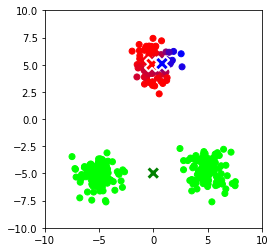

In [17]:
gmm = MultivariateGaussianMixture(n_components=3)
gmm.fit(x_train)
p = gmm.classify_proba(x_train)

plt.scatter(x_train[:, 0], x_train[:, 1], c=p)
plt.scatter(gmm.mu[:, 0], gmm.mu[:, 1], s=200, marker='X', lw=2, c=['red', 'green', 'blue'], edgecolor="white")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect("equal")
plt.show()

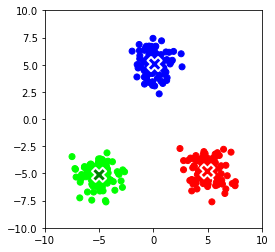

In [18]:
gmm2 = MultivariateGaussianMixture(n_components=3)
gmm2.fit(x_train)
p = gmm2.classify_proba(x_train)

plt.scatter(x_train[:, 0], x_train[:, 1], c=p)
plt.scatter(gmm2.mu[:, 0], gmm2.mu[:, 1], s=200, marker='X', lw=2, c=['red', 'green', 'blue'], edgecolor="white")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect("equal")
plt.show()

# 4. An Alternative View of EM

# A toy problem using EM

Given a set of data $D = \{(x_{1n}, x_{2n}\}_{n=1}^{N}$, where we have values for every $x_{n1}$, the first dimension, and have only a partial observation on the second dimension $x_{2n}$. Assume that we these data follow a 2-dimensional Gaussian distribution, we will infer the values of missing (hidden) values in the second dimension.
$$\begin{pmatrix}x_{1}\\x_{2}\end{pmatrix} \sim \cal{N}(\begin{pmatrix}\mu_1\\\mu_2\end{pmatrix}, \begin{pmatrix}\sigma_1^2 \quad \rho \sigma_1\sigma_2\\\rho \sigma_1\sigma_2 \quad \sigma_2^2\end{pmatrix})$$


First we create a data set, where we have the luxury of knowing the true values. We delete part of the data along the second direction and try to recover it. We plot the samples below as blue circles. Now say we lose the y-values of the last-20 pieces of data. We are left with a missing data or hidden data or latent-variables problem. We plot both datasets below, with the y-values of the lost points set to 0

In [19]:
sig1=1
sig2=0.75
mu1=1.85
mu2=1
rho=0.82
means=np.array([mu1, mu2])
cov = np.array([
    [sig1**2, sig1*sig2*rho],
    [sig2*sig1*rho, sig2**2]
])
means, cov
np.random.seed(2018)

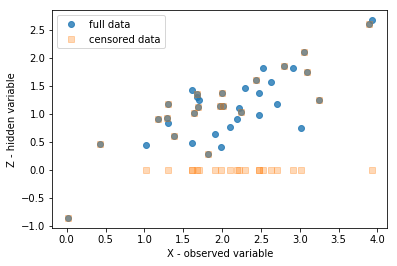

In [20]:
samples=np.random.multivariate_normal(means, cov, size=40)
samples_censored=np.copy(samples)
samples_censored[20:,1]=0
plt.plot(samples[:,0], samples[:,1], 'o', alpha=0.8, label='full data')
plt.plot(samples_censored[:,0], samples_censored[:,1], 's', alpha=0.3, label='censored data')
plt.gca().set_xlabel(r"X - observed variable")
plt.gca().set_ylabel(r"Z - hidden variable")
plt.legend();

If we have no hidden variables, i.e., complete data. Then it is easy to estimate the original Gaussian distribution. The maximum likelihood estimation is: $$\mu_{ML} = \frac{1}{N}\sum_{n=1}^{N}\mathbf{x}_n$$

and $$\Sigma_{ML} = \frac{1}{N}\sum_{n=1}^{N}(\mathbf{x}_n - \mu_{ML})(\mathbf{x}_n - \mu_{ML})^{T}$$

In [21]:
def plot_gaussian(mean, cov, linestyles='solid'):
    x1 = np.linspace(-1, 5, 100)
    x2 = np.linspace(-1, 4, 100)
    X1, X2 = np.meshgrid(x1,x2)
    Z = np.array([X1, X2]).transpose(1,2,0)
    model = multivariate_normal(mean=mean, cov=cov)
    plt.contourf(X1, X2, model.pdf(Z), alpha = 0.2, linestyles=linestyles)
    

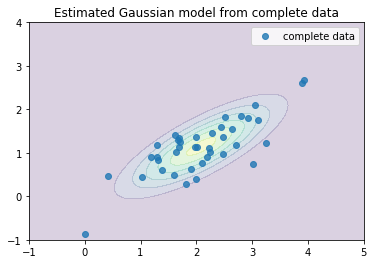

In [22]:
# MLE estimate N(x|mu, cov) from complete data
mu1 = lambda s: np.mean(s[:,0])
mu2 = lambda s: np.mean(s[:,1])
s1 = lambda s: np.std(s[:,0])
s2 = lambda s: np.std(s[:,1])
rho = lambda s: np.mean((s[:,0] - mu1(s))*(s[:,1] - mu2(s)))/(s1(s)*s2(s))

# plot model
true_empirical_mean = np.array([mu1(samples), mu2(samples)])
true_empirical_cov = np.array([[s1(samples)**2, rho(samples)*s1(samples)*s2(samples)],
                          [rho(samples)*s1(samples)*s2(samples), s2(samples)**2]])
plot_gaussian(true_empirical_mean, true_empirical_cov)

# plot complete data
plt.plot(samples[:,0], samples[:,1], 'o', alpha=0.8, label='complete data')
plt.title('Estimated Gaussian model from complete data');
plt.legend();

But we don't. So we shall follow an iterative process to find them. 


Let's us remember the conditional gaussian distribution formula. That is:

$$\mathbf{x} = \begin{pmatrix}\mathbf{x}_a\\ \mathbf{x}_b\end{pmatrix} \sim \cal{N}(\mu, \Sigma),$$ where

$$\mu = \begin{pmatrix}\mu_a \\ \mu_b\end{pmatrix}$$

and $$\Sigma = \begin{pmatrix}\Sigma_{aa} \quad \Sigma_{ab}\\ \Sigma_{ba} \quad \Sigma_{bb}\end{pmatrix}$$

Then we have the conditional distribution $p(\mathbf{x}_a \mid \mathbf{x}_b)$ is a also Gaussian distribution with mean and covarviance as follows.

$$\mu_{a|b} =  \mu_a + \Sigma_{ab}\Sigma_{bb}^{-1}(\mathbf{x}_b - \mu_b)$$ and

$$\Sigma_{a|b} = \Sigma_{aa} - \Sigma_{ab}\Sigma_{bb}^{-1}\Sigma_{ba}$$

In [23]:
mu1s=[]
mu2s=[]
s1s=[]
s2s=[]
rhos=[]

Bur remember our data are missing in the y-direction. Assume 0 and go. Since we are using the MLE of the full-data likelihood, with this assumption we can use the MLE formulae. This is called M-step or maximization step since we used the MLE formulae

In [24]:
# perform MLE
mu1s.append(mu1(samples_censored))
mu2s.append(mu2(samples_censored))
s1s.append(s1(samples_censored))
s2s.append(s2(samples_censored))
rhos.append(rho(samples_censored))
mu1s,mu2s,s1s,s2s,rhos

([2.087091924389681],
 [0.5687353198998151],
 [0.8095441939356555],
 [0.7551576594592054],
 [0.3359937627277947])

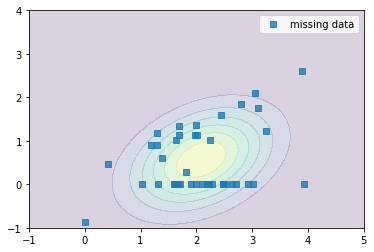

In [25]:
empirical_mean = np.array([mu1s[0], mu2s[0]])
empirical_cov = np.array([[s1s[0]**2, rhos[0]*s1s[0]*s1s[0]],
                          [rhos[0]*s1s[0]*s1s[0], s2s[0]**2]])
plot_gaussian(mean=empirical_mean, cov=empirical_cov)

# plot complete data
plt.plot(samples_censored[:,0], samples_censored[:,1], 's', alpha=0.8, label='missing data')
plt.legend();

Now having new estimates of our parameters due to our (fake) y-data, lets go in the other direction. Using these parameters let us calculate new y-values.

One way we might do this is to replace the old-missing-y values with the means of these fixing the parameters of the multi-variate normal and the non-missing data. In other words:

In [26]:
# this is due to the discussion of conditional Gaussian
def ynew(x, mu1, mu2, s1, s2, rho):
    return mu2 + rho*(s2/s1)*(x - mu1)
    

In [27]:
newys=ynew(samples_censored[20:,0], mu1s[0], mu2s[0], s1s[0], s2s[0], rhos[0])
newys

array([0.41836441, 0.74052422, 0.23434226, 1.14648744, 0.44756033,
       0.5390403 , 0.69096987, 0.7048072 , 0.68980989, 0.51353001,
       0.42084781, 0.44114778, 0.82880611, 0.60175183, 0.32407001,
       0.7630257 , 0.6320556 , 0.61101177, 0.85921627, 0.57297278])

In [28]:
for step in range(1,20):
    # inferring hidden values
    samples_censored[20:,1] = newys
    #M-step
    mu1s.append(mu1(samples_censored))
    mu2s.append(mu2(samples_censored))
    s1s.append(s1(samples_censored))
    s2s.append(s2(samples_censored))
    rhos.append(rho(samples_censored))
    #E-step
    newys=ynew(samples_censored[20:,0], mu1s[step], mu2s[step], s1s[step], s2s[step], rhos[step])
df=pd.DataFrame.from_dict(dict(mu1=mu1s, mu2=mu2s, s1=s1s, s2=s2s, rho=rhos))
df

,mu1,mu2,s1,s2,rho
0,2.087092,0.568735,0.809544,0.755158,0.335994
1,2.087092,0.873244,0.809544,0.580764,0.660383
2,2.087092,1.035801,0.809544,0.551689,0.817495
3,2.087092,1.122437,0.809544,0.558864,0.870373
4,2.087092,1.168566,0.809544,0.568971,0.887767
5,2.087092,1.193114,0.809544,0.576027,0.894075
6,2.087092,1.206174,0.809544,0.580235,0.896641
7,2.087092,1.213120,0.809544,0.582598,0.897791
8,2.087092,1.216815,0.809544,0.583890,0.898342
9,2.087092,1.218780,0.809544,0.584587,0.898619


Voila. We converge to stable values of our parameters.
But they may not be the ones we seeded the samples with. The Em algorithm is only good upto finding local minima, and a finite sample size also means that the minimum found can be slightly different.

In [29]:
estimated_mean = df[['mu1', 'mu2']].iloc[19].values
rho = df.rho.iloc[19]
s1 = df.rho.iloc[19]
s2 = df.rho.iloc[19]
estimated_cov = np.array([[s1**2, rho*s1*s2],[rho*s1*s2, s2**2]])

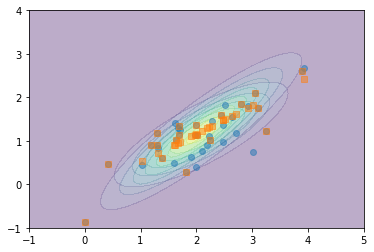

In [30]:
plt.plot(samples[:,0], samples[:,1], 'o', label='complete data', alpha=0.5)
plt.plot(samples_censored[:,0], samples_censored[:,1], 's', label='inferred data', alpha=0.5)
plot_gaussian(true_empirical_mean, true_empirical_cov)
plot_gaussian(estimated_mean, estimated_cov, linestyles='dashdot')

We can see that Gaussian model that we learn using EM algorithm almost match the Gaussian
that we can learn if we have complete data.